In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"

VIS_CONF_THRESHOLD = 0.9


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [2]:
import matplotlib.pyplot as plt
import torch
from posingpixels.cotracker import CoMeshTracker
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from pytorch3d.ops.perspective_n_points import efficient_pnp
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks


from posingpixels.utils.cotracker import unscale_by_crop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
dataset = YCBinEOATDataset(video_dir, obj_dir)
tracker = CoMeshTracker(
    dataset,
    # support_grid=10,
    offline=False,
    # crop=False,
    # visible_background=True,
    # downcast=True,
    # better_initialization=False,
    # limit=100,
    # interpolation_steps=80,
    axis_rotation_steps=40,
    final_interpolation_steps=40,
    query_frames=[0, 10, 20, 30],
    device=device,
)

In [4]:
pred_tracks, pred_visibility, pred_confidence = tracker()

Creating init video


Preparing images for CoTracker: 100%|██████████| 817/817 [00:19<00:00, 41.16it/s]
Processing batches: 103it [00:51,  1.99it/s]                         


In [5]:
video = load_video_images(tracker.cotracker_input_dir, limit=tracker.limit)
init_video = load_video_images(
    tracker.init_video_dir, limit=tracker.limit, file_type="jpg"
)
video_original = load_video_images(tracker.dataset.video_rgb_dir, limit=tracker.limit)

In [6]:
visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
)

gt_tracks, gt_visibility = get_gt_tracks(tracker)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="gt_video",
    threshold=VIS_CONF_THRESHOLD,
)
pred_tracks_original = unscale_by_crop(
    pred_tracks[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

full_video = torch.cat([init_video, video_original], dim=1)[:, : tracker.limit]
visualize_results(
    full_video,
    pred_tracks_original,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="original",
    threshold=VIS_CONF_THRESHOLD,
)

gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker, crop=False)
visualize_results(
    full_video,
    torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility_original).to(device))
    .unsqueeze(0)
    .float(),
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="gt_original",
    threshold=VIS_CONF_THRESHOLD,
)

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/original.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_original.mp4


In [47]:
from typing import List
from posingpixels.utils.evaluation import compute_tapvid_metrics
import numpy as np

def get_most_confident_views(pred_confidence: torch.Tensor, query_to_point: torch.Tensor, num_points: int, queries_lengths: List[int]) -> torch.Tensor:
    """
    Find the query indices with highest confidence scores for each point at each timestamp.
    
    Args:
        pred_confidence: Tensor of shape (T, Q) containing confidence scores for each query at each timestamp
        query_to_point: Tensor of shape (Q,) mapping each query index to its corresponding point index
        num_points: Number of unique points (N)
        queries_lengths: List of lengths of each query sequence
    
    Returns:
        Tensor of shape (T, N) containing the query indices with highest confidence for each point at each timestamp
    """
    T, Q = pred_confidence.shape
    V = len(queries_lengths)
    
    query_to_view = torch.zeros(Q, device=pred_confidence.device).int()
    prev = 0
    for i, length in enumerate(queries_lengths):
        query_to_view[prev:prev + length] = i
        prev += length
    
    # Step 1: Find the most confident view for each timestamp
    # Create a mask of shape (Q, V) where mask[q, v] = 1 if query q belongs to view v
    query_view_mask = torch.zeros(Q, V, device=pred_confidence.device).int()
    query_indices = torch.arange(Q, device=pred_confidence.device).int()
    query_view_mask[query_indices, query_to_view] = 1
    
    # Calculate average confidence per view at each timestamp
    # Shape: (T, Q, 1)
    confidence_expanded = pred_confidence.unsqueeze(-1)
    # Shape: (T, Q, V)
    view_confidence = confidence_expanded * query_view_mask.unsqueeze(0)
    
    # Get the sum and count of confidence scores per view
    view_conf_sum = view_confidence.sum(dim=1)  # Shape: (T, V)
    view_conf_count = query_view_mask.sum(dim=0)  # Shape: (V,)
    
    # Calculate average confidence per view
    view_conf_avg = view_conf_sum / view_conf_count  # Shape: (T, V)
    
    # Get the most confident view for each timestamp
    best_view_indices = torch.argmax(view_conf_avg, dim=1)  # Shape: (T,)
    
    # Step 2: Create a mask for queries belonging to the best view at each timestamp
    best_view_mask = query_view_mask[:, best_view_indices]  # Shape: (1, T, Q)
    
    # Step 3: Find the most confident queries for points in the best view
    # Create a mask for queries belonging to each point
    query_point_mask = torch.zeros(Q, num_points, device=pred_confidence.device)
    query_point_mask[query_indices, query_to_point] = 1
    
    # Mask confidence scores for queries not in the best view
    masked_confidence = pred_confidence.unsqueeze(-1) * query_point_mask.unsqueeze(0)  # Shape: (T, Q, N)
    masked_confidence = masked_confidence * best_view_mask.T.unsqueeze(-1)
    
    # Find the query indices with maximum confidence for each point
    masked_confidence[masked_confidence == 0] = float('-inf')
    best_query_indices = torch.argmax(masked_confidence, dim=1)  # Shape: (T, N)
    
    return best_view_indices, best_view_mask, best_query_indices

def get_most_confident_queries(pred_confidence: torch.Tensor, query_to_point: torch.Tensor, num_points: int) -> torch.Tensor:
    """
    Find the query indices with highest confidence scores for each point at each timestamp.
    
    Args:
        pred_confidence: Tensor of shape (T, Q) containing confidence scores for each query at each timestamp
        query_to_point: Tensor of shape (Q,) mapping each query index to its corresponding point index
        num_points: Number of unique points (N)
    
    Returns:
        Tensor of shape (T, N) containing the query indices with highest confidence for each point at each timestamp
    """
    T, Q = pred_confidence.shape
    
    # Create a mask of shape (Q, N) where mask[q, p] = 1 if query q corresponds to point p
    query_point_mask = torch.zeros(Q, num_points, device=pred_confidence.device)
    query_indices = torch.arange(Q, device=pred_confidence.device)
    query_point_mask[query_indices, query_to_point] = 1
    
    # Reshape confidence scores to (T, Q, 1) for broadcasting
    confidence_expanded = pred_confidence.unsqueeze(-1)  # Shape: (T, Q, 1)
    
    # Broadcast confidence scores across points and mask out irrelevant queries
    # Shape: (T, Q, N)
    masked_confidence = confidence_expanded * query_point_mask.unsqueeze(0)
    
    # Find the query indices with maximum confidence for each point
    # Use a very low value for masking to ensure masked values aren't selected
    masked_confidence[masked_confidence == 0] = float('-inf')
    
    # Get the query indices with maximum confidence for each point at each timestamp
    # Shape: (T, N)
    best_query_indices = torch.argmax(masked_confidence, dim=1)
    
    return best_query_indices

tensor_query_to_point = torch.tensor(tracker.query_to_point)
true_indexes = torch.nonzero(tensor_query_to_point)
true_indexes[:, 1].flatten()

best_query_indices = get_most_confident_queries(pred_confidence[0] * pred_visibility[0], true_indexes[:, 1].flatten(), tracker.num_object_points)
# _, _, best_query_indices = get_most_confident_views(pred_confidence[0] * pred_visibility[0], true_indexes[:, 1].flatten(), tracker.num_object_points, tracker.queries_sizes)

best_coords = pred_tracks[:, torch.arange(tracker.limit).unsqueeze(1), best_query_indices]
best_vis = pred_visibility[:, torch.arange(tracker.limit).unsqueeze(1), best_query_indices]
best_conf = pred_confidence[:, torch.arange(tracker.limit).unsqueeze(1), best_query_indices]
best_coords_original = unscale_by_crop(
    best_coords[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

In [48]:
query_points = tracker.query_2d_points[np.newaxis, :tracker.num_object_points]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = best_vis.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = best_coords.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = best_conf.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = VIS_CONF_THRESHOLD
evaluation_points = pred_confidence_ * pred_visibility_ > threshold
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode="first",
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

(1, 202, 3)
(1, 202, 817)
(1, 202, 817, 2)
(1, 202, 817)
(1, 202, 817, 2)
(1, 202, 817)
occlusion_accuracy [0.95606354]
average_jaccard [0.2199101]
average_pts_within_thresh [0.31888745]
pts_within_1 [0.05816718]
jaccard_1 [0.02926226]
pts_within_2 [0.10748636]
jaccard_2 [0.05544909]
pts_within_4 [0.19606095]
jaccard_4 [0.10598493]
pts_within_8 [0.43548387]
jaccard_8 [0.27040765]
pts_within_16 [0.79723888]
jaccard_16 [0.63844656]
dict_keys(['occlusion_accuracy_over_time', 'occlusion_accuracy', 'time_pts_within_1', 'per_point_pts_within_1', 'pts_within_1', 'time_jaccard_1', 'per_point_jaccard_1', 'jaccard_1', 'time_pts_within_2', 'per_point_pts_within_2', 'pts_within_2', 'time_jaccard_2', 'per_point_jaccard_2', 'jaccard_2', 'time_pts_within_4', 'per_point_pts_within_4', 'pts_within_4', 'time_jaccard_4', 'per_point_jaccard_4', 'jaccard_4', 'time_pts_within_8', 'per_point_pts_within_8', 'pts_within_8', 'time_jaccard_8', 'per_point_jaccard_8', 'jaccard_8', 'time_pts_within_16', 'per_point_

/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:139: RuntimeWarning: invalid value encountered in divide
  occ_acc_ = np.sum(np.equal(pred_occluded, gt_occluded) & evaluation_points, axis=1) / np.sum(evaluation_points, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:177: RuntimeWarning: invalid value encountered in divide
  frac_correct_time_ = np.sum(count_correct_, axis=1) / np.sum(count_visible_points_, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:206: RuntimeWarning: invalid value encountered in divide
  jaccard_time_ = np.sum(true_positives_, axis=1) / (np.sum(gt_positives_ + false_positives_, axis=1))


Text(0.5, 1.0, 'Number of points considered per time step with visibility * confidence > 0.9')

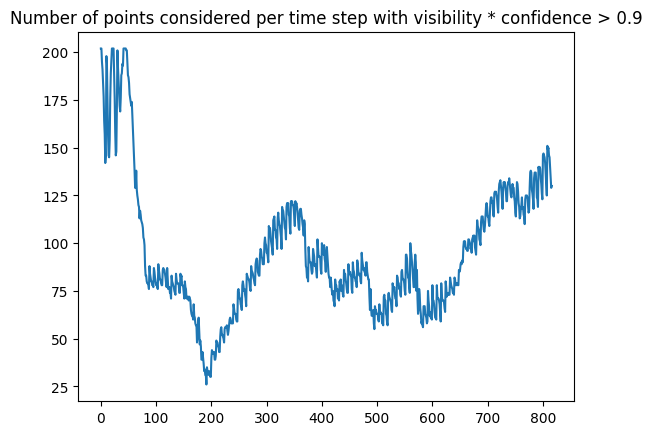

In [49]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(
    f"Number of points considered per time step with visibility * confidence > {threshold}"
)

Text(0, 0.5, 'Value')

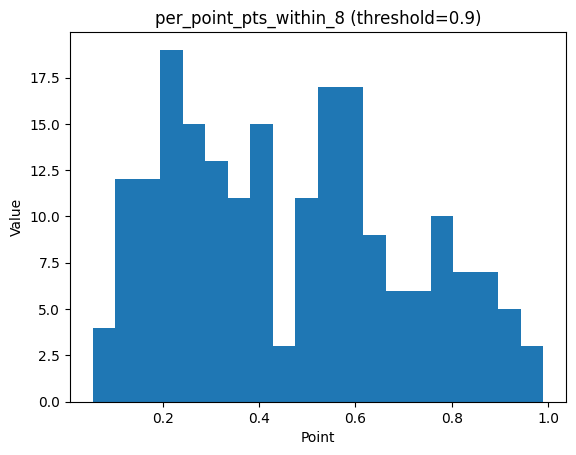

In [50]:
metric_name = "per_point_pts_within_8"
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if "time" in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(
    tracker.interpolation_steps, color="r", linestyle="--"
) if "time" in metric_name else None
plt.title(f"{metric_name} (threshold={threshold})")
plt.xlabel("Frame" if "time" in metric_name else "Point")
plt.ylabel("Value")

In [ ]:
from typing import Optional
import mediapy
from posingpixels.optimization import (
    MultiTimestampRenderPoseModel6D,
    render_train_model,
)
from posingpixels.utils.geometry import (
    apply_pose_to_points_batch,
    render_points_in_2d_batch,
)
from posingpixels.visualization import overlay_bounding_box_on_video


def solve_pnp(
    points_3d: torch.Tensor,
    points_2d: torch.Tensor,
    K: torch.Tensor,
    image_size: torch.Tensor,
    device: torch.device,
    weights: Optional[torch.Tensor] = None,
):
    if len(points_2d.shape) == 2:
        points_2d = points_2d.clone().unsqueeze(0)
    B, N, _ = points_2d.shape
    if len(points_3d.shape) == 2:
        points_3d = points_3d.clone().unsqueeze(0).repeat(B, 1, 1)
    if len(image_size.shape) == 1:
        image_size = image_size.unsqueeze(0).repeat(B, 1)
    if weights is not None and len(weights.shape) == 1:
        weights = weights.clone().unsqueeze(0).repeat(B, 1)
    if len(K.shape) == 2:
        K = K[:3, :3].clone().unsqueeze(0).repeat(B, 1, 1)

    p3d = points_3d
    p2d_h = torch.cat(
        (points_2d[..., :2], torch.ones(B, N, 1, device=device).to(device)), dim=-1
    )
    # Flip focal length (because of the way pytorch3d is implemented)
    # K[:, 0, 0] = -K[:, 0, 0]; K[:, 1, 1] = -K[:, 1, 1]
    p_inv = torch.inverse(K).transpose(1, 2)
    p2d_uncal = torch.matmul(p2d_h, p_inv)
    transform = efficient_pnp(p3d, p2d_uncal[..., :2], weights)

    poses = torch.eye(4).to(device).unsqueeze(0).repeat(B, 1, 1)
    poses[:, :3, :3] = transform.R.transpose(1, 2)
    poses[:, :3, 3] = transform.T

    return poses

considered_limit = tracker.limit
x = (
    torch.tensor(tracker.unposed_3d_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(considered_limit, 1, 1)
)
gt_poses = torch.tensor(tracker.get_gt_poses()[:considered_limit]).float().to(device)
gt_posed_x = apply_pose_to_points_batch(x, gt_poses[:, :3, :3], gt_poses[:, :3, 3])
y_gt = render_points_in_2d_batch(
    gt_posed_x, torch.tensor(tracker.K[:3, :3]).float().to(device)
)

y = best_coords_original.detach().clone().squeeze(0)[:considered_limit]


weights = (
    (best_vis * best_conf)
    .float()[:considered_limit]
)
weights = weights / weights.sum(dim=1, keepdim=True)
weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
weights = weights.squeeze(0)


result_poses = solve_pnp(
    x,
    y,
    torch.tensor(tracker.K).to(device).float(),
    torch.tensor((tracker.H, tracker.W)).to(device),
    device,
    weights=weights,
)

model = MultiTimestampRenderPoseModel6D(
    points=x[0],
    num_timestamps=considered_limit,
    # initial_R=result_poses[:, :3, :3],
    # initial_T=result_poses[:, :3, 3],
    initial_R=gt_poses[0, :3, :3],
    initial_T=gt_poses[0, :3, 3],
    device=device,
)

camKs = (
    torch.tensor(tracker.K[np.newaxis, :].repeat(considered_limit, axis=0))
    .to(device)
    .float()
)

_, my_predictions = render_train_model(
    model,
    camKs,
    y,
    weights=weights,
    num_epochs=4000,
    warmup_steps=100,
    max_lr=0.02,
    early_stop_min_steps=100,
    reconstruction_loss="huber",
    # temporal_consistency_weight=0,
    # reconstruction_loss_clip=500,
    # reconstruction_loss_clip_start_epoch=500,
)

# my_predicted_poses = model.get_pose_matrices()
my_predicted_poses = result_poses


video_permuted = full_video[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:considered_limit].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:considered_limit], fps=15)

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 28.55% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))
/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 0.42% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))
/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 37.39% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))
/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 21.42% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))
 62%|██████▏   | 2499/4000 [00:07<00:04, 326.25it/s]


0.0013568521031207597


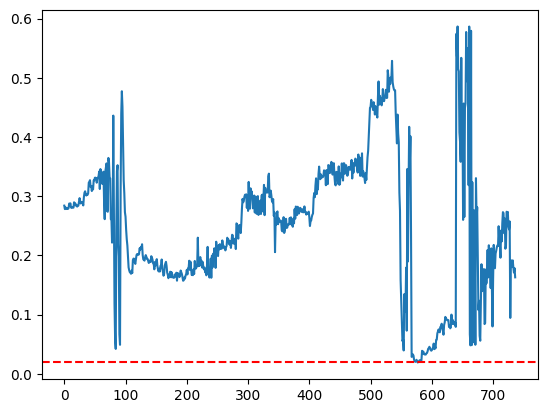

In [58]:
from posingpixels.utils.evaluation import compute_add_metrics

add_metrics = []
model_3D_pts = np.array(dataset.get_mesh().vertices)
percentage = 0.1
threshold = dataset.obj_diameter * percentage
for i in range(tracker.interpolation_steps, considered_limit):
    add_metrics.append(
        compute_add_metrics(
            model_3D_pts,
            dataset.obj_diameter,
            my_predicted_poses[i].detach().cpu().numpy(),
            tracker.get_gt_pose(i),
            percentage=percentage,
            return_error=True,
        )
    )
print(np.mean(np.array(add_metrics) < threshold, axis=0))

plt.plot(add_metrics)
# Plot horizontal line at percentage
plt.axhline(threshold, color="r", linestyle="--")